!pip install torch segmentation_models_pytorch tqdm albumentations opencv-python scikit-learn scipy

In [9]:
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import scipy
import json
import numpy as np

from skimage.segmentation import find_boundaries
from skimage.morphology import thin

# 1 -> Frontal wall
# 2 -> Left wall
# 3 -> Right wall
# 4 -> Floor 
# 5 -> Ceiling

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 25
EPOCHS = 30
LR = 1e-3
IMAGE_SIZE = (128, 128) 

DATASET_PATH = "LSUN2016_surface_relabel/surface_relabel/train"

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = cv2.imread(f'{self.paths[idx]}.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        mask = scipy.io.loadmat(f'{self.paths[idx]}.mat')['layout']
        mask = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
        mask = find_boundaries(mask, mode='thick', connectivity=2).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

In [4]:
files = os.listdir(DATASET_PATH)

paths = [os.path.join(DATASET_PATH, os.path.splitext(f)[0]) for f in files if f.endswith('.jpg')]

train_paths, val_paths = train_test_split(
    paths, test_size=0.2, random_state=5
)

In [5]:
train_transform = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.6),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.ElasticTransform(
        alpha=10,
        sigma=50,
        p=0.3
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [6]:
train_dataset = SegmentationDataset(train_paths, transform=train_transform)
val_dataset = SegmentationDataset(val_paths, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6399999].


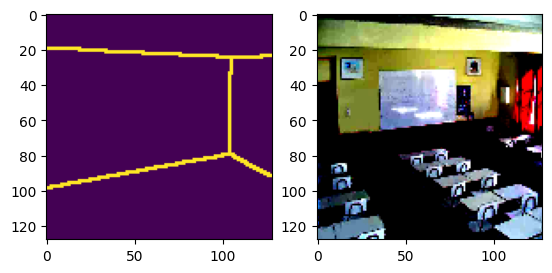

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_dataset[6][1])
ax[1].imshow(train_dataset[6][0].permute(1, 2, 0))

In [10]:
model = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights=None,
    in_channels=3,
    classes=2,
    activation=None
).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 70.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [11]:
model.load_state_dict(torch.load('init.pth', map_location=DEVICE))
model = model.to(DEVICE)

In [9]:
model.load_state_dict(torch.load('model/model_w1.pth', map_location=DEVICE))
model = model.to(DEVICE)

In [36]:
model.load_state_dict(torch.load('model/checkpointsv3/model_2.pth', map_location=DEVICE))
model = model.to(DEVICE)

In [12]:
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": []
}
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    pbar = tqdm(total=len(train_dataset), desc=f"Epoch {epoch+1}", unit="img")
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        # plt.imshow(outputs[0][1].detach().numpy())
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        pbar.update(BATCH_SIZE)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            val_loss += loss_fn(outputs, masks).item()

    avg_train_loss = train_loss/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"model/checkpoints/model_{epoch + 1}.pth")

    with open("model/checkpoints/metrics_history.json", "w", encoding="utf-8") as f:
        json.dump(history, f, indent=4)

Epoch 1: 3525img [04:20, 17.09img/s]                                                          

Epoch 1/30 | Train Loss: 0.4153 | Val Loss: 0.4036



Epoch 1: 3525img [04:30, 13.02img/s]                                | 0/3515 [00:00<?, ?img/s]

Epoch 2: 100%|██████████████████████████████████████████▊| 3500/3515 [04:38<00:01, 12.18img/s]
Epoch 2: 3525img [04:39, 13.84img/s]                                                          
Epoch 2: 3525img [04:59, 13.84img/s]

Epoch 2/30 | Train Loss: 0.3178 | Val Loss: 0.3745


Epoch 2: 3525img [05:05, 11.53img/s]                                | 0/3515 [00:00<?, ?img/s]
Epoch 3: 3525img [04:23, 17.59img/s]                                                          

Epoch 3/30 | Train Loss: 0.2793 | Val Loss: 0.3642



Epoch 3: 3525img [04:31, 12.98img/s]                                | 0/3515 [00:00<?, ?img/s]

Epoch 4: 100%|██████████████████████████████████████████▊| 3500/3515 [04:37<00:01, 12.36img/s]
Epoch 4: 3525img [04:39, 13.91img/s]                                                          
Epoch 4: 3525img [04:52, 13.91img/s]

Epoch 4/30 | Train Loss: 0.2614 | Val Loss: 0.3664


Epoch 4: 3525img [05:05, 11.54img/s]                                | 0/3515 [00:00<?, ?img/s]
Epoch 5: 3525img [04:26, 17.59img/s]                                                          

Epoch 5/30 | Train Loss: 0.2388 | Val Loss: 0.3597



Epoch 5: 3525img [04:31, 12.97img/s]                                | 0/3515 [00:00<?, ?img/s]

Epoch 6: 100%|██████████████████████████████████████████▊| 3500/3515 [04:38<00:01, 12.53img/s]
Epoch 6: 3525img [04:40, 14.17img/s]                                                          
Epoch 6: 3525img [04:54, 14.17img/s]

Epoch 6/30 | Train Loss: 0.2258 | Val Loss: 0.3578


Epoch 6: 3525img [05:07, 11.48img/s]                                | 0/3515 [00:00<?, ?img/s]
Epoch 7: 3525img [04:27, 17.39img/s]                                                          

Epoch 7/30 | Train Loss: 0.2141 | Val Loss: 0.4274



Epoch 7: 3525img [04:34, 12.84img/s]                                | 0/3515 [00:00<?, ?img/s]

Epoch 8: 100%|██████████████████████████████████████████▊| 3500/3515 [04:39<00:01, 12.32img/s]
Epoch 8: 3525img [04:41, 13.93img/s]                                                          
Epoch 8: 3525img [04:53, 13.93img/s]

Epoch 8/30 | Train Loss: 0.2063 | Val Loss: 0.4534


Epoch 8: 3525img [05:07, 11.47img/s]                                | 0/3515 [00:00<?, ?img/s]
Epoch 9: 3525img [04:25, 17.59img/s]                                                          

Epoch 9/30 | Train Loss: 0.1985 | Val Loss: 0.4048



Epoch 9: 3525img [04:31, 12.98img/s]                                | 0/3515 [00:00<?, ?img/s]

Epoch 10: 100%|█████████████████████████████████████████▊| 3500/3515 [04:37<00:01, 12.91img/s]
Epoch 10: 3525img [04:38, 14.57img/s]                                                         
Epoch 10: 3525img [04:54, 14.57img/s]

Epoch 10/30 | Train Loss: 0.1887 | Val Loss: 0.4575


Epoch 10: 3525img [05:04, 11.57img/s]                               | 0/3515 [00:00<?, ?img/s]
Epoch 11: 3525img [04:19, 17.31img/s]                                                         

Epoch 11/30 | Train Loss: 0.1826 | Val Loss: 0.4552



Epoch 11: 3525img [04:32, 12.94img/s]                               | 0/3515 [00:00<?, ?img/s]

Epoch 12: 100%|█████████████████████████████████████████▊| 3500/3515 [04:39<00:01, 12.38img/s]
Epoch 12: 3525img [04:40, 14.14img/s]                                                         
Epoch 12: 3525img [04:57, 14.14img/s]

Epoch 12/30 | Train Loss: 0.1749 | Val Loss: 0.4791


Epoch 12: 3525img [05:07, 11.47img/s]                               | 0/3515 [00:00<?, ?img/s]
Epoch 13: 3525img [04:20, 17.45img/s]                                                         

Epoch 13/30 | Train Loss: 0.1724 | Val Loss: 0.4982



Epoch 13: 3525img [04:30, 13.04img/s]                               | 0/3515 [00:00<?, ?img/s]

Epoch 14:  99%|█████████████████████████████████████████▌| 3475/3515 [04:37<00:03, 12.25img/s]

KeyboardInterrupt: 


Epoch 14:  99%|█████████████████████████████████████████▌| 3475/3515 [04:49<00:03, 12.25img/s]

In [119]:
torch.save(model.state_dict(), f"model/checkpoints/model_final_bad.pth")

In [13]:
model.load_state_dict(torch.load('model/checkpoints/model_6.pth'))

<All keys matched successfully>

In [14]:
from skan import Skeleton, summarize
import pandas as pd

def clean_skeleton_graph(skel, min_edge_length=10):
    skel = skel.astype(bool)
    skeleton_obj = Skeleton(skel)
    summary = summarize(skeleton_obj)

    degrees = skeleton_obj.degrees
    is_endpoint = degrees == 1
    valid_edges = []
    for idx, row in summary.iterrows():
        src = int(row['node-id-src'])
        dst = int(row['node-id-dst'])
        length = row['branch-distance']

        if (is_endpoint[src] or is_endpoint[dst]) and length < min_edge_length:
            continue
        valid_edges.append(idx)

    clean_skel = np.zeros_like(skel, dtype=np.uint8)
    for idx in valid_edges:
        coords = skeleton_obj.path_coordinates(idx)
        coords = np.round(coords).astype(int)
        clean_skel[coords[:, 0], coords[:, 1]] = 1

    return clean_skel

In [15]:
from skimage.morphology import skeletonize

def get_mask(img, model):
    sh = 0
    if isinstance(img, str):
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sh = img.shape
        img = cv2.resize(img, IMAGE_SIZE)
        img = val_transform(image=img)['image']
    else:
        sh = img.shape
        img = cv2.resize(img, IMAGE_SIZE)

    msk_pred = np.where(torch.sigmoid(model(torch.Tensor(img.reshape(1, 3, 128, 128)))) > 0.5, 1, 0)[0, 1].astype(np.uint8)
    msk_pred = cv2.morphologyEx(msk_pred, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=np.uint8))
    msk_pred = cv2.resize(np.where(msk_pred, 255, 0).astype(np.uint8), sh[1::-1], interpolation=cv2.INTER_NEAREST)
    skeleton = skeletonize(msk_pred)
    skeleton = clean_skeleton_graph(skeleton, int((max(sh[0], sh[1]) * 0.3)))
    return msk_pred, skeleton

/tmp/ipykernel_57974/1984429251.py:7: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  summary = summarize(skeleton_obj)


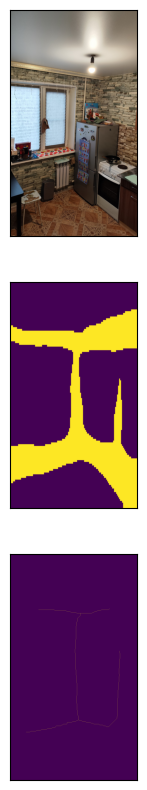

In [21]:
fig, ax = plt.subplots(3, 1, subplot_kw={'xticks': [], 'yticks': []}, figsize=(12, 10))

# p = paths[25]
p = 'img/data1/5'

img = cv2.imread(p + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)

msk, skel = get_mask(p + '.jpg', model)
ax[1].imshow(msk)
ax[2].imshow(skel)

# m = cv2.imread(p + '.png')
# ax[3].imshow(m)